# Assignment 05 - Hypothesis Simulation 

## Author - AngelaQiqianYang



## Instructions
Use the <a href="https://archive.ics.uci.edu/ml/datasets/Automobile">automotive data set</a> to perform the following:

1. Identify a likely distribution for price and several other features.
2. Compute basic summary statistics by both classical, bootstrap, and Bayesian methods
3. Compute confidence intervals for these summary statistics by classical, bootstrap, and Bayesian methods
4. Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant:
            Classical tests
            Tukey’s Honest Significant Differences (HSD)
            Bootstrap methods
            Bayesian model


Please visit the UCI Maching Learning Repository Automobile Data set (Links to an external site.)Links to an external site. for more information about the attributes. You can build off your previous work, but you must look also look at other attributes aside from fuel type, aspiration, drive-wheels, and body style.

In [161]:
# Load necessary libraries
import pandas as pd 
import numpy as np 
import os 
import statsmodels.api as sm
import scipy
import scipy.stats as ss
import statsmodels.stats.weightstats as ws
from statistics import mean
import statsmodels.stats.power as ssp #ANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd # turkey HSD test
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [162]:
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"

In [163]:
#file_name = 'Automobile price data _Raw_.csv'

In [164]:
auto_df = pd.read_csv(fileName)

In [165]:
auto_df.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

### Step 1: Data Preparation

In [166]:
auto_df = auto_df.replace(to_replace="?", value=float("NaN"))
auto_df.isnull().sum()

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

I decided to eliminate the null value in all columns, but not for column "normalized-losses". The reason is that 41 of normalized-losses data are null value. Giving the row dataset is very small (~200), that is a large portion of raw data. However, I don't apply normalized-losses in the following analysis. In order to keep as much data as possible, it is better to keep the null value in normalized-losses has lots of null value. 

In [167]:
auto_df = auto_df.dropna(subset=['num-of-doors', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price'])

In [168]:
auto_df.describe()

,symboling,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,0.797927,98.923834,174.326425,65.893782,53.869948,2561.507772,128.124352,10.143627,25.326425,30.787565
std,1.235582,6.152409,12.478593,2.137795,2.394770,526.700026,41.590452,3.977491,6.387828,6.816910
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,98.000000,8.500000,19.000000,25.000000
50%,1.000000,97.000000,173.200000,65.400000,54.100000,2414.000000,120.000000,9.000000,25.000000,30.000000
75%,2.000000,102.400000,184.600000,66.900000,55.700000,2952.000000,146.000000,9.400000,30.000000,34.000000
max,3.000000,120.900000,208.100000,72.000000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000


In [169]:
# change object value to be integer 
auto_df['bore'] = auto_df['bore'].astype(float)
auto_df['stroke'] = auto_df['stroke'].astype(float)
auto_df['horsepower'] = auto_df['horsepower'].astype(int)
auto_df['peak-rpm'] = auto_df['peak-rpm'].astype(int)
auto_df['price'] = auto_df['price'].astype(int)
auto_df.dtypes

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower             int32
peak-rpm               int32
city-mpg               int64
highway-mpg            int64
price                  int32
dtype: object

In [170]:
my_df = auto_df

### Step 2: Data Distribution 
Identify a likely distribution for price and several other features. I would exam if the price, city-mpg, highway-mpg, horsepower and curb-weight would be normal distribution. 

#### 2.1 visulize the data distribution in general

c:\users\sduya\appdata\local\programs\python\python37-32\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
c:\users\sduya\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


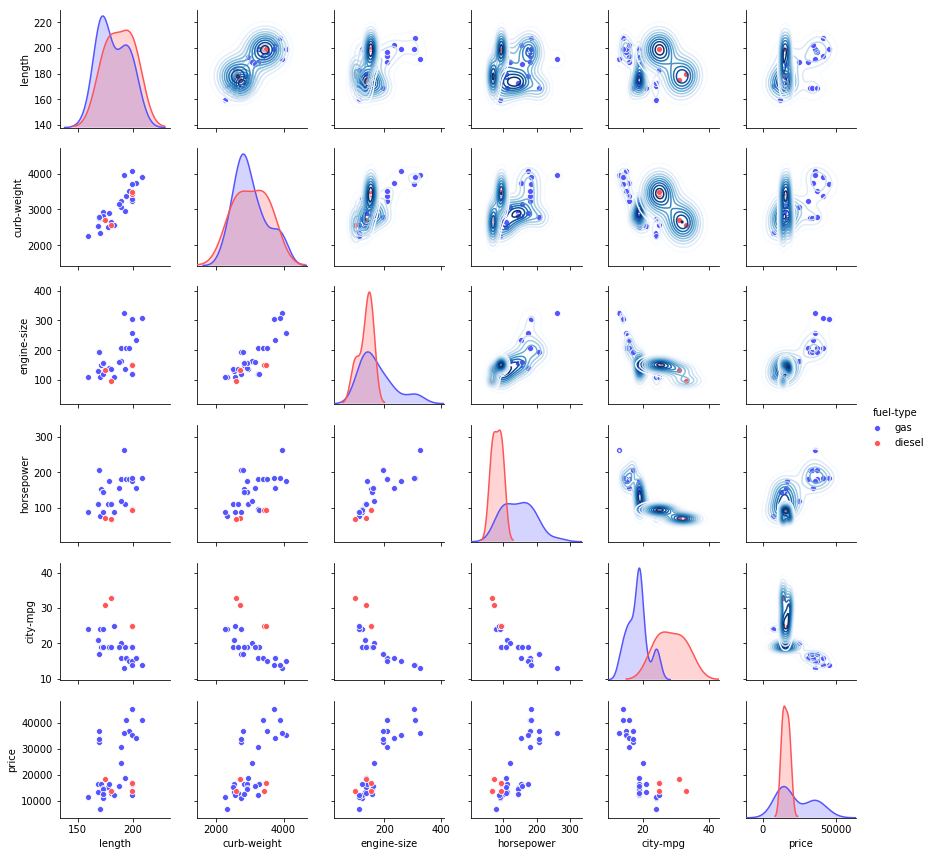

In [171]:
#plt.hist(auto_df.loc[HasNan, 'price'])
fix_cols = ["length", "curb-weight", "engine-size", "horsepower", "city-mpg", "price", "fuel-type"] 
sns.pairplot(my_df.loc[HasNan, fix_cols], hue='fuel-type', 
             palette="seismic", diag_kind="kde", 
             size=2).map_upper(sns.kdeplot, cmap="Blues")

#### 2.2 Price
I did two normality tests seperatly for the original auto price and sample means of auto price. auto-vehicle is right skewed, with mean value 13,285. I used shapiro method to test my null hypothesis (the dirbution is normal). The result reject my hypothesis. <font color = 'red'> The price is not a normal distribution. </font> However, I computed a list of 500 sample means from samples of size 50 from the price distribution. A histogram and Q-Q plot are created from the results and plotted. Even though the original distribution of price is not a perfect normal distribution. The distribution of the sample is very close to a normal distribution.

The mean value of pice is:  13285.025906735751
The standard deviation of pice is:  8089.082885693348


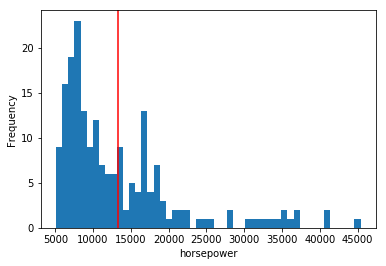

In [172]:
## look up the distribution of price
mean_price = my_df['price'].mean()
std_price = my_df['price'].std()
print ('The mean value of pice is: ', mean_price)
print ('The standard deviation of pice is: ',  std_price)
def hist_plot(vec, bins):
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('horsepower')
hist_plot(auto_df['price'], 50)

In [173]:
### normality test for price
from scipy.stats import shapiro
stat, p = shapiro(my_df['price'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.801, p=0.000
Sample does not look Gaussian (reject H0)


Estimated mean (13275.925) vs actual mean (13285.026)
Estimated s.d. (1159.144) vs actual s.d. (8089.083)


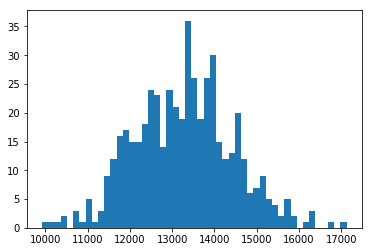

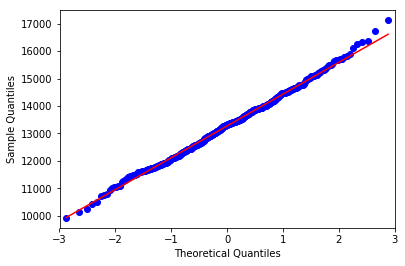

In [77]:
### normality test for the sample means 
# generate array of random samples
price_means = np.array([
        np.random.choice(my_df['price'], size=50, replace=True).mean()
        for i in range(500)])
price_mean = price_means.mean()
price_std = price_means.std()
print('Estimated mean (%.3f) vs actual mean (%.3f)' % (price_mean, my_df['price'].mean()))
print('Estimated s.d. (%.3f) vs actual s.d. (%.3f)' % (price_std, my_df['price'].std()))

# plot the means
breaks = np.linspace(price_means.min(), price_means.max(), num=50)
# plot histogram
_ = pyplot.hist(price_means, bins=breaks)
# qq-plot 
_ = sm.qqplot(price_means, line='s')

#### 2.3 horse power
horse power is right skewed. With mean value: 103, standard diviation: 38, it is not a normal distribution. However, a list of 1000 sample means, from samples of size 50 from the price distribution, shows a very clear normal distribition. 

The mean value of pice is:  103.48186528497409
The standard deviation of pice is:  37.96010697433018


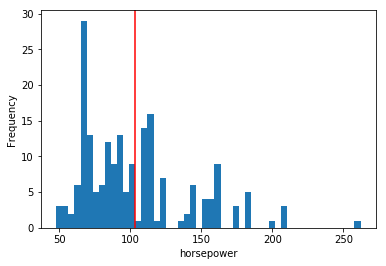

In [75]:
## look up the distribution of price
mean_price = my_df['horsepower'].mean()
std_price = my_df['horsepower'].std()
print ('The mean value of pice is: ', mean_price)
print ('The standard deviation of pice is: ',  std_price)
def hist_plot(vec, bins):
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('horsepower')
hist_plot(auto_df['horsepower'], 50)

In [73]:
### normality test for price
from scipy.stats import shapiro
stat, p = shapiro(my_df['horsepower'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.902, p=0.000
Sample does not look Gaussian (reject H0)


Estimated mean (103.213) vs actual mean (103.482)
Estimated s.d. (5.233) vs actual s.d. (37.960)


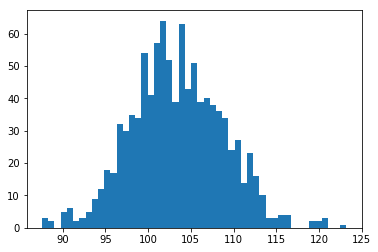

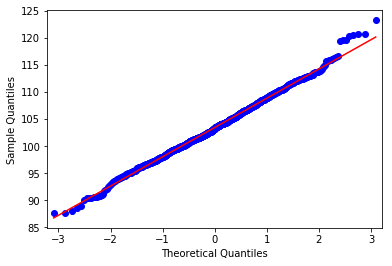

In [78]:
### normality test for the sample means 
# generate array of random samples
horsepower_means = np.array([
        np.random.choice(my_df['horsepower'], size=50, replace=True).mean()
        for i in range(1000)])
horsepower_mean = horsepower_means.mean()
horsepower_std = horsepower_means.std()
print('Estimated mean (%.3f) vs actual mean (%.3f)' % (pop_mean, my_df['horsepower'].mean()))
print('Estimated s.d. (%.3f) vs actual s.d. (%.3f)' % (pop_std, my_df['horsepower'].std()))

# plot the means
breaks = np.linspace(horsepower_means.min(), horsepower_means.max(), num=50)
# plot histogram
_ = pyplot.hist(horsepower_means, bins=breaks)
# qq-plot 
_ = sm.qqplot(horsepower_means, line='s')

#### 2.4  Coorelation 
From the correlation heat map, we can concluded that mpg is highly (negatively) correlated to length, width, cube weight, engine size, horse power, price and bore. horse power is highly (positively) correlated to length, width, cube weight and engine size.

In [206]:
my_df_corr = my_df[['length', 'width', 'height', 'curb-weight', 
                    'engine-size', 'bore', 'stroke', 'horsepower', 'compression-ratio', 
                    'peak-rpm', 'city-mpg', 'highway-mpg', 'price']].corr()
my_df_corr

,length,width,height,curb-weight,engine-size,bore,stroke,horsepower,compression-ratio,peak-rpm,city-mpg,highway-mpg,price
length,1.000000,0.857368,0.491050,0.882694,0.686998,0.606373,0.121888,0.589650,0.156061,-0.276144,-0.702143,-0.731264,0.695928
width,0.857368,1.000000,0.310640,0.867640,0.739903,0.541633,0.188733,0.621532,0.188631,-0.247612,-0.657153,-0.702009,0.754649
height,0.491050,0.310640,1.000000,0.305837,0.026906,0.182445,-0.054338,-0.081730,0.253934,-0.257334,-0.111166,-0.159850,0.136234
curb-weight,0.882694,0.867640,0.305837,1.000000,0.857188,0.645070,0.175349,0.762154,0.161030,-0.278528,-0.777763,-0.818104,0.835368
engine-size,0.686998,0.739903,0.026906,0.857188,1.000000,0.581854,0.214518,0.845325,0.025257,-0.217769,-0.716378,-0.737531,0.888778
bore,0.606373,0.541633,0.182445,0.645070,0.581854,1.000000,-0.065038,0.572972,-0.004172,-0.273766,-0.601369,-0.608804,0.546295
stroke,0.121888,0.188733,-0.054338,0.175349,0.214518,-0.065038,1.000000,0.102913,0.199600,-0.068420,-0.031248,-0.040274,0.096007
horsepower,0.589650,0.621532,-0.081730,0.762154,0.845325,0.572972,0.102913,1.000000,-0.203818,0.101383,-0.833615,-0.812078,0.812453
compression-ratio,0.156061,0.188631,0.253934,0.161030,0.025257,-0.004172,0.199600,-0.203818,1.000000,-0.439741,0.314648,0.249669,0.074483
peak-rpm,-0.276144,-0.247612,-0.257334,-0.278528,-0.217769,-0.273766,-0.068420,0.101383,-0.439741,1.000000,-0.061032,-0.008412,-0.103835


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]), <a list of 13 Text xticklabel objects>)

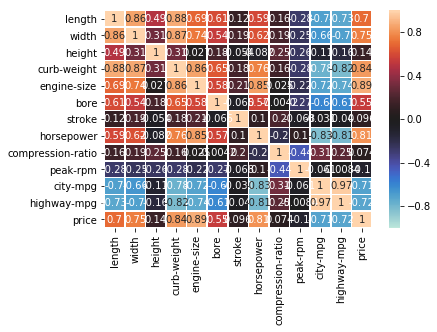

In [207]:
sns.heatmap(my_df_corr, 
            vmin=-1, 
            vmax=1, 
            center=0, 
            annot=True, #show the correlatrion value in cell
            linewidths=.5) 
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')

### Step 3: Basic summary statistics 
I would like to see if body styles effect the price significantly. The data have five different body styles. They are Sedan, Hatchback, Wagon, Hardtop, and Convertible. I will only test sedan and hatchback, by using both classical, bootstrap, and Bayesian methods. 

#### 3.1 Classical: t-test
I tested the significant impact level between two variables horsepower and body style. From the t-test plot, we can visually inspect that sedan or hatchback don't make a significant impact on horsepower. Again, from the P value computation, we can second-time conclude that p value is large and difference is small enough, so two types of body won't make a signivicant impact on horse power.

##### Horsepower CI 

In [79]:
print('Estimated mean (%.3f) vs actual mean (%.3f)' % (horsepower_mean, my_df['horsepower'].mean()))
print('Estimated s.d. (%.3f) vs actual s.d. (%.3f)' % (horsepower_std, my_df['horsepower'].std()))

Estimated mean (103.403) vs actual mean (103.482)
Estimated s.d. (5.406) vs actual s.d. (37.960)


In [80]:
alpha = 0.95
half_width = scipy.stats.norm.ppf((1 + alpha)/2, loc=horsepower_mean, scale=horsepower_std) - horsepower_mean
print('The half width is %.2f' % half_width)

# generating confidence intervals
ci_low = horsepower_mean - half_width
ci_high = horsepower_mean + half_width

print('The actual mean is %.2f' % my_df['horsepower'].mean())
print('The %.2f level CI is (%.2f , %.2f)' % (alpha, ci_low, ci_high))

The half width is 10.60
The actual mean is 103.48
The 0.95 level CI is (92.81 , 114.00)


##### Horsepower and Body style

In [114]:
# Define functions for t test, chi test, and plot t test. 
def t_test(a, b, alpha, alternative='two-sided'):    
    import scipy.stats as ss
    import statsmodels.stats.weightstats as ws
    diff = a.mean() - b.mean()
    res = ss.ttest_ind(a, b)
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()
    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index) 

def hist_mean_ci(vec, t_test, bins):
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Price')

def plot_t(a, b, t_test, cols, nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histogram of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

In [105]:
# Create a data frame with the counts and the means of the groups
def count_mean(data, strat_name):
    groups = data.groupby(strat_name) # Create the groups
    return pd.DataFrame({'count': groups.size(), 
                        'mean': groups.aggregate(np.mean).loc[:, 'horspower']})
# Create stratified group
def stratify(data, p, strat_name):
    groups = data.groupby(strat_name) # Create the groups
    nums = min(groups.size()) # Find the size of the smallest group
    num = int(p * data.shape[0]) # Compute the desired number of samples per group
    if num <= nums: # If sufficient group size, sample each group and return. 
        return groups.apply(lambda x: x.sample(n=num))
    else: # Oops. p is to large
        pmax = nums / data.shape[0]
        print('The maximum value of p = ' + str(pmax))

In [100]:
sedan = np.array(my_df[my_df['body-style'] == 'sedan']['horsepower'])
hatchback = np.array(my_df[my_df['body-style'] == 'hatchback']['horsepower'])

DegFreedom    135.184455
Difference      7.340235
Statistic       1.209836
PValue          0.228208
Low95CI        -4.611526
High95CI       19.291995
dtype: float64


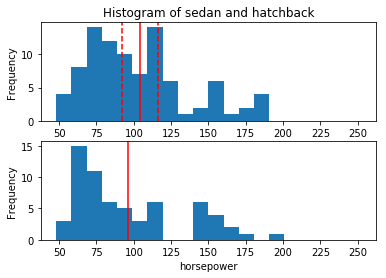

In [115]:
test_body = t_test(sedan, hatchback, alpha = 0.05) # 95% confidence interval
print(test_body)
plot_t(sedan, hatchback, test_body, ['sedan', 'hatchback'])   

In [142]:
stratified_body = t_test(sedan, hatchback, alpha = 0.05) # 95% confidence interval
print(stratified_body)

DegFreedom    135.184455
Difference      7.340235
Statistic       1.209836
PValue          0.228208
Low95CI        -4.611526
High95CI       19.291995
dtype: float64


#### 3.2 Bootstrap & CI
The whole smaple size if not big=. So let's use some resampling method to compute a bigger sample size. From the plot below, the distribution of the bootstrap means, between sedan and hatchback, do overlap a lot. <font color='red'>So, we may get the same conclusion that sedan or hatchback doesn't impact the horsepower signicantly.</fopnt>

In [126]:
sedan_df = my_df[my_df['body-style'] == 'sedan']
hatchback_df = my_df[my_df['body-style'] == 'hatchback']
#sedan_df.sample(frac=1, replace=True).head()
#hatchback_df.sample(frac=1, replace=True).head()

In [125]:
sedan_df.sample(frac=0.1, replace=True)['horsepower'].mean()

106.17391304347827

In [132]:
hatchback_df.sample(frac=0.1, replace=True)['horsepower'].mean()

72.0

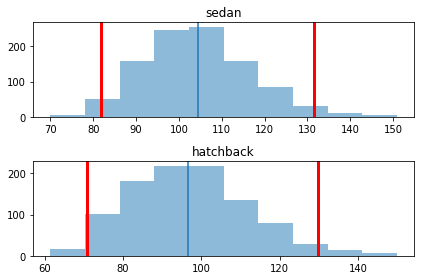

In [140]:
# number of samples to return
n_replicas = 1000

# create series of sample means with 1000 replicas
sedan_bootstrap_means = pd.Series([
    sedan_df.sample(frac=0.1, replace=True)['horsepower'].mean()
    for i in range(n_replicas)])

hatchback_bootstrap_means = pd.Series([
        hatchback_df.sample(frac=0.1, replace=True)['horsepower'].mean()
        for i in range(n_replicas)])

plot_dists(sedan_bootstrap_means, hatchback_bootstrap_means, 
           nbins=80, a_label='sedan', b_label='hatchback')

#### 3.3 Bayesian methods
I would like to see how the is probability distribution of body styles. 
###### <font color='red'>Conclusion: The likelyhood of sedan being in the auto is between 0.4 - 0.6 </font>

In [157]:
import itertools

In [175]:
#One-hot encoding (dummy variables) for a categorical column 
# I am interested in code 'body-style' variable
print (my_df['body-style'].value_counts())
my_df.loc[:, "sedan"] = (my_df.loc[:, "body-style"] == "sedan").astype(int)
my_df.loc[:, "hatchback"] = (my_df.loc[:, "body-style"] == "hatchback").astype(int)
my_df.loc[:, "wagon"] = (my_df.loc[:, "body-style"] == "wagon").astype(int)
my_df.loc[:, "hardtop"] = (my_df.loc[:, "body-style"] == "hardtop").astype(int)
my_df.loc[:, "convertible"] = (my_df.loc[:, "body-style"] == "convertible").astype(int)

sedan          92
hatchback      63
wagon          24
hardtop         8
convertible     6
Name: body-style, dtype: int64


In [192]:
sedan = np.array(my_df['sedan'])

In [193]:
sedan

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1])

In [194]:
# using the binomial distribution formula
N = len(sedan)  # sample size
n_sedan = sum(sedan)  # number of sedan 
n_not_sedan = N - n_sedan # number not sedan

print('sedan auto = %d \ not sedan auto = %d'
    '\nProbability of sedan auto = %.1f' 
      % (n_sedan, n_not_sedan, n_sedan / (n_sedan + n_not_sedan)))

sedan auto = 92 \ not sedan auto = 101
Probability of sedan auto = 0.5


In [195]:
N = 100
# create array to feed to binomial dist calc
p = np.linspace(.01, .99, num=N)
p

array([0.01      , 0.01989899, 0.02979798, 0.03969697, 0.04959596,
       0.05949495, 0.06939394, 0.07929293, 0.08919192, 0.09909091,
       0.1089899 , 0.11888889, 0.12878788, 0.13868687, 0.14858586,
       0.15848485, 0.16838384, 0.17828283, 0.18818182, 0.19808081,
       0.2079798 , 0.21787879, 0.22777778, 0.23767677, 0.24757576,
       0.25747475, 0.26737374, 0.27727273, 0.28717172, 0.29707071,
       0.3069697 , 0.31686869, 0.32676768, 0.33666667, 0.34656566,
       0.35646465, 0.36636364, 0.37626263, 0.38616162, 0.39606061,
       0.4059596 , 0.41585859, 0.42575758, 0.43565657, 0.44555556,
       0.45545455, 0.46535354, 0.47525253, 0.48515152, 0.49505051,
       0.50494949, 0.51484848, 0.52474747, 0.53464646, 0.54454545,
       0.55444444, 0.56434343, 0.57424242, 0.58414141, 0.5940404 ,
       0.60393939, 0.61383838, 0.62373737, 0.63363636, 0.64353535,
       0.65343434, 0.66333333, 0.67323232, 0.68313131, 0.6930303 ,
       0.70292929, 0.71282828, 0.72272727, 0.73262626, 0.74252

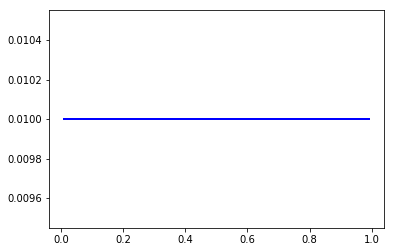

In [189]:
# plug into bionmial formula
pp = [1./N] * N
pyplot.plot(p, pp, linewidth=2, color='blue')

Text(0,0.5,'Likelihood')

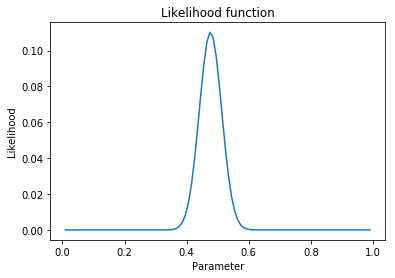

In [197]:
# sum to unity = make sum to 1
def likelihood(p, data):
    k = sum(data)
    N = len(data)
    # Compute Binomial likelihood
    l = scipy.special.comb(N, k) * p**k * (1-p)**(N-k)
    # Normalize the likelihood to sum to unity
    return l/sum(l)

l = likelihood(p, sedan)
pyplot.plot(p, l)
pyplot.title('Likelihood function')
pyplot.xlabel('Parameter')
pyplot.ylabel('Likelihood')

In [198]:
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity

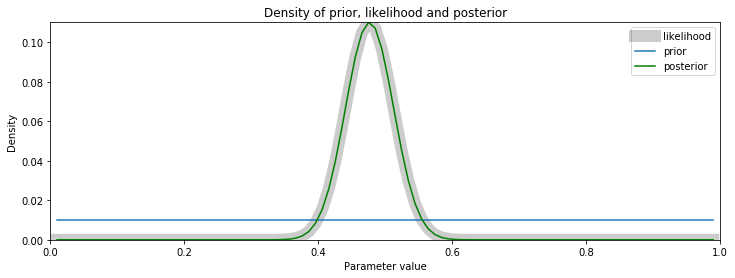

In [199]:
def plot_post(prior, like, post, x):
    # get the largest number from priors, likelihood and posterior
    # for setting plot height
    maxy = max(max(prior), max(like), max(post))
    pyplot.figure(figsize=(12, 4))
    pyplot.plot(x, like, label='likelihood', linewidth=12, color='black', alpha=.2)
    pyplot.plot(x, prior, label='prior')
    pyplot.plot(x, post, label='posterior', color='green')
    pyplot.ylim(0, maxy)
    pyplot.xlim(0, 1)
    pyplot.title('Density of prior, likelihood and posterior')
    pyplot.xlabel('Parameter value')
    pyplot.ylabel('Density')
    pyplot.legend()
    
post = posterior(pp, l)
plot_post(pp, l, post, p)

In [200]:
print('Maximum of the prior density = %.3f' % max(pp))
print('Maximum likelihood = %.3f' % max(l))
print('MAP = %.3f' % max(post))

Maximum of the prior density = 0.010
Maximum likelihood = 0.110
MAP = 0.110


#### 3.4 Tukey’s Honest Significant Differences (HSD)

We tested sedan and hatchback body style above. However, there are five body tyles in the reality. If we want to understand every tyle of body, how do they impact horsepower, the HSD test become very handy to solve this.

We made our null hypothesis that different body style won't impact the horsepower significantly. 

Below statistic result shows that the F statistic is fairly large and the p-value is very small! We can reject the null hypothesis that the five body type variables have the same mean, as the probability of the differences arising from random chance is quite low. 

Exam the John Tukey's Honest Significant Differences (HSD) plot below. There is a line with a dot shown for each variable. The dot is the mean and the line shows the range of the confidence interval for  that mean. If the difference in means is significant at the 95% confidence level, the confidence intervals will not overlap. The hatchback type body is not overlay with hardtop, convertible, and sedan. 

##### <font color='red'> Conclusion:  
 - <font color='red'> changing body type from hardtop to any of sedan, hatchback, wagon does have significant impact on auto horsepower. 


In [145]:
# make five types of auto body data ready
sedan = np.array(my_df.loc[my_df.loc[:, 'body-style'] == 'sedan', 'horsepower']) 
hatchback = np.array(my_df.loc[my_df.loc[:, 'body-style'] == 'hatchback', 'horsepower']) 
wagon = np.array(my_df.loc[my_df.loc[:, 'body-style'] == 'wagon', 'horsepower']) 
hardtop = np.array(my_df.loc[my_df.loc[:, 'body-style'] == 'hardtop', 'horsepower']) 
convertible = np.array(my_df.loc[my_df.loc[:, 'body-style'] == 'convertible', 'horsepower']) 

Text(0.5,1,'Box Plot by Body Type')

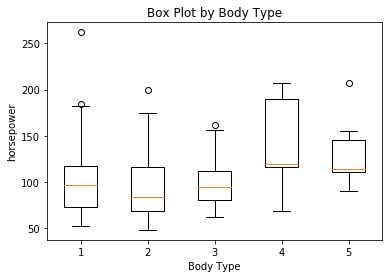

In [146]:
plt.boxplot([sedan, hatchback, wagon, hardtop, convertible])
plt.ylabel('horsepower')
plt.xlabel('Body Type')
plt.title('Box Plot by Body Type')

In [151]:
f_statistic, p_value = ss.f_oneway(sedan, hatchback, wagon, hardtop, convertible)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 3.730833419066526
P-value = 0.006025149902067096


In [155]:
Tukey_HSD = pairwise_tukeyhsd(my_df['horsepower'], my_df['body-style'])
print(Tukey_HSD)

  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1     group2  meandiff  lower    upper  reject
------------------------------------------------------
convertible  hardtop  10.5833  -44.3452 65.5118 False 
convertible hatchback -34.746  -78.2004  8.7083 False 
convertible   sedan   -27.4058 -70.2604 15.4489 False 
convertible   wagon   -33.9167 -80.3397 12.5064 False 
  hardtop   hatchback -45.3294 -83.5034 -7.1553  True 
  hardtop     sedan   -37.9891 -75.4791 -0.4991  True 
  hardtop     wagon    -44.5   -86.0221 -2.9779  True 
 hatchback    sedan    7.3402  -9.2922  23.9727 False 
 hatchback    wagon    0.8294  -23.5677 25.2265 False 
   sedan      wagon   -6.5109  -29.8231 16.8014 False 
------------------------------------------------------


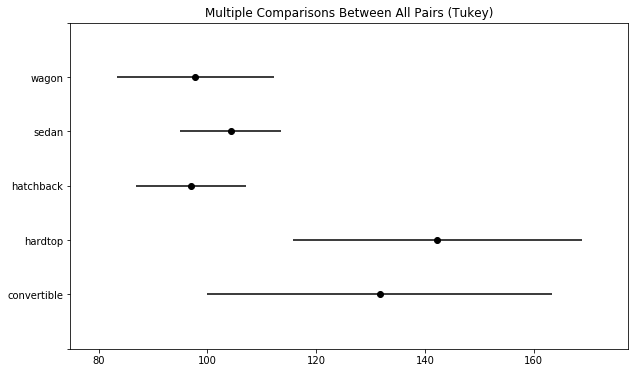

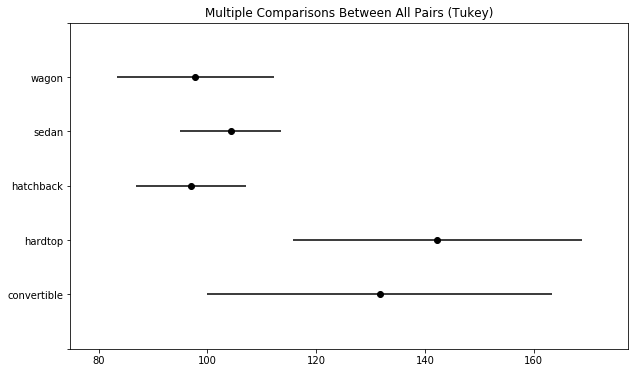

In [156]:
Tukey_HSD.plot_simultaneous()

In [201]:
print ('Thanks for the review! ')

Thanks for the review! 
